In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

AUTOTUNE = tf.data.experimental.AUTOTUNE 

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_size = [64,64]
batch_size = 64
epoch = 100

In [45]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    'Alz_data/train2/',
        labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5121 files belonging to 2 classes.
Using 4097 files for training.


In [46]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    'Alz_data/train2',
        labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
#     color_mode='grayscale',
    seed=123,
    image_size=(64,64),
    batch_size=batch_size,
)

Found 5121 files belonging to 2 classes.
Using 1024 files for validation.


In [47]:
train_data.class_names

['Demented', 'NonDemented']

In [48]:
class_names = ['Demented', 'NonDemented']
train_data.class_names = class_names
val_data.class_names = class_names

NUM_CLASSES = len(class_names)

In [49]:
NUM_CLASSES = len(class_names)

TypeError: only integer scalar arrays can be converted to a scalar index

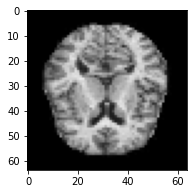

In [50]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_data.class_names[labels[i]])
    plt.axis("off")

In [51]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_data = train_data.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_data = val_data.map(one_hot_label, num_parallel_calls=AUTOTUNE)

TypeError: in user code:

    <ipython-input-51-0602fbd515a8>:2 one_hot_label  *
        label = tf.one_hot(label, NUM_CLASSES)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/array_ops.py:4122 one_hot
        return gen_array_ops.one_hot(indices, depth, on_value, off_value, axis,
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/gen_array_ops.py:6325 one_hot
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/op_def_library.py:576 _apply_op_helper
        _SatisfiesTypeConstraint(base_type,
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/op_def_library.py:57 _SatisfiesTypeConstraint
        raise TypeError(

    TypeError: Value passed to parameter 'indices' has DataType float32 not in list of allowed values: uint8, int32, int64


In [52]:
datagen = ImageDataGenerator(validation_split=0.2, 
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False)
train_generator = datagen.flow_from_directory(
        'Alz_data/train2',
        target_size=(64,64),
        batch_size=100,
        color_mode='grayscale',
#         class_mode='categorical',
        subset='training')
validation_generator = datagen.flow_from_directory(
        'Alz_data/train2',
        target_size=(64,64),
        color_mode='grayscale',
        batch_size=100,
#         class_mode='categorical',
        subset='validation')

# test_generator = datagen.flow_from_directory(
#         'Alz_data/test2',
#         target_size=(64,64),
#         color_mode='grayscale',
#         batch_size=100)
# #         class_mode='categorical',


Found 4097 images belonging to 2 classes.
Found 1024 images belonging to 2 classes.


In [73]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
        tf.keras.Input(shape=(*image_size, 1)),
        
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.5),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    
    return model

In [74]:
model = build_model()

METRICS = [
        tf.keras.metrics.AUC(name='AUC'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
model.compile(
        optimizer='adam',
        loss=tf.losses.BinaryCrossentropy(),
        metrics=METRICS
    )

In [75]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

checkpoint_filepath = 'src/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)


In [76]:
history = model.fit(
    train_data,
    validation_data=val_data,
    callbacks=[early_stopping_cb, lr_scheduler, model_checkpoint_callback],
    epochs=epoch)

Epoch 1/100


ValueError: in user code:

    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:748 train_step
        loss = self.compiled_loss(
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/losses.py:1605 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/backend.py:4829 binary_crossentropy
        bce = target * math_ops.log(output + epsilon())
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/math_ops.py:1141 binary_op_wrapper
        raise e
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/math_ops.py:1125 binary_op_wrapper
        return func(x, y, name=name)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/math_ops.py:1457 _mul_dispatch
        return multiply(x, y, name=name)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/math_ops.py:509 multiply
        return gen_math_ops.mul(x, y, name)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/gen_math_ops.py:6175 mul
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/op_def_library.py:742 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/func_graph.py:591 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/ops.py:3477 _create_op_internal
        ret = Operation(
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/ops.py:1974 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 2 and 4 for '{{node binary_crossentropy/mul}} = Mul[T=DT_FLOAT](IteratorGetNext:1, binary_crossentropy/Log)' with input shapes: [?,2], [?,4].


In [ ]:
model.summary()

In [67]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    'Alz_data/test2/',
            labels='inferred',
    label_mode='categorical',
#     color_mode='grayscale',
    image_size=image_size,
    batch_size=batch_size)

Found 1098 files belonging to 2 classes.


In [68]:
score = model.evaluate(test_data)

18/18 [==============================] - 0s 11ms/step - loss: 0.7945 - AUC: 0.7143 - precision: 0.6494 - recall: 0.6494
